In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jockeroika/human-bone-fractures-image-dataset")

print("Path to dataset files:", path)

d:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\bfd\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\toshi\.cache\kagglehub\datasets\jockeroika\human-bone-fractures-image-dataset\versions\1


In [1]:
# imports

import os
import shutil

import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
import copy
import math

from PIL import Image

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset, Subset


d:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\bfd\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# print(os.listdir(path))

local_folder = "./dataset3"

# os.mkdir(local_folder)

# shutil.copytree(path, local_folder, dirs_exist_ok=True)

# rename folder name
# dataset3/fractures/Bone Fractures Detection
# old_name =  './dataset3/fractures/Bone Fractures Detection'
# new_name = './dataset3/hbfmid'

# os.rename(old_name, new_name)

# folder_name = "./dataset2/fractures"
# train_target = "./dataset2/train"
# test_target = "./dataset2/test"

In [3]:
# Set paths
# for yoga
# train_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\train"
# val_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\valid"
# test_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\test"

# train_img_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\train\images"
# val_img_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\valid\images"
# test_img_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\test\images"

# train_labels_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\train\labels"
# val_labels_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\valid\labels"
# test_labels_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset3\hbfmid\test\labels"

# for asus
train_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset3\hbfmid\train"
val_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset3\hbfmid\valid"
test_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset3\hbfmid\test"

train_img_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset3\hbfmid\train\images"
val_img_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset3\hbfmid\valid\images"
test_img_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset3\hbfmid\test\images"

train_labels_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset3\hbfmid\train\labels"
val_labels_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset3\hbfmid\valid\labels"
test_labels_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset3\hbfmid\test\labels"

In [4]:
def keep_first_object_only(labels_dir):
    """
    For each YOLO-style label txt file, keep only the first line (first object).
    """
    for txt_file in os.listdir(labels_dir):
        if txt_file.endswith(".txt"):
            path = os.path.join(labels_dir, txt_file)
            with open(path, 'r') as f:
                lines = f.readlines()
            if lines:
                # Keep only the first object
                with open(path, 'w') as f:
                    f.write(lines[0])


keep_first_object_only(train_labels_dir)
keep_first_object_only(val_labels_dir)
keep_first_object_only(test_labels_dir)

📊 Train class counts: {8: 531, 7: 66, 4: 297, 2: 54, 6: 12, 5: 48, 0: 150, 1: 75, 9: 90, 3: 21}
📊 Train class counts: {8: 47, 4: 28, 2: 7, 7: 5, 6: 3, 5: 7, 9: 9, 0: 14, 1: 7, 3: 1}
📊 Test class counts: {7: 3, 4: 16, 8: 22, 5: 2, 9: 8, 0: 9, 2: 3, 1: 1}


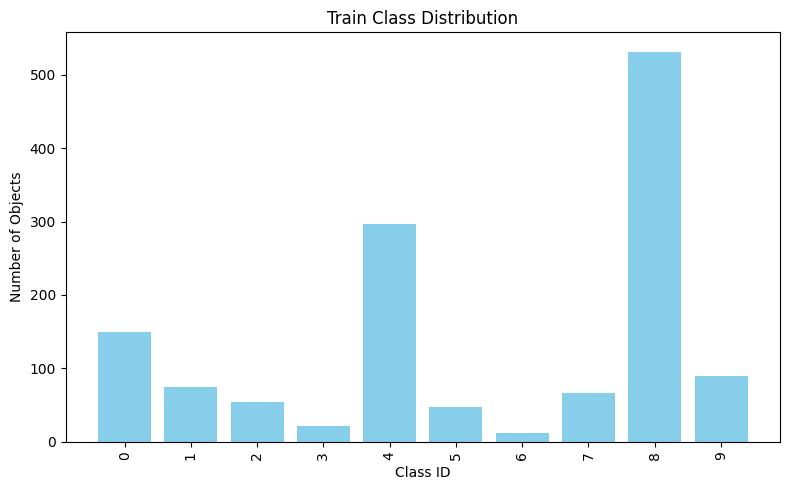

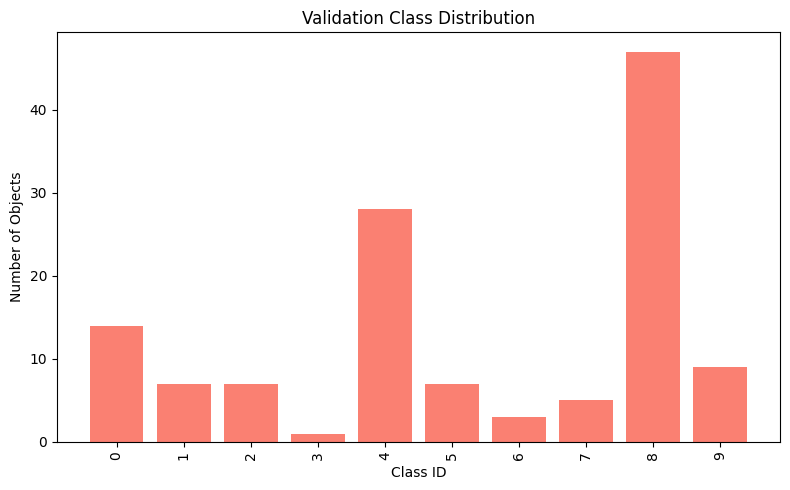

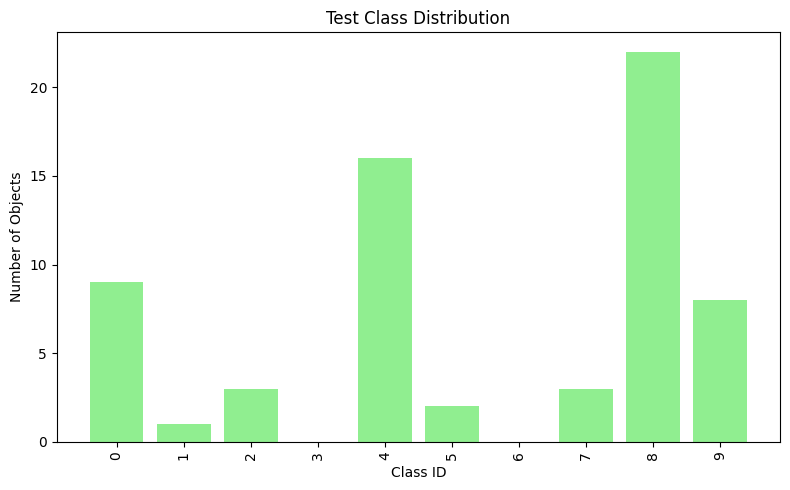

In [5]:
def count_images_in_folder(root_dir):
    class_counts = defaultdict(int)
    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            n_images = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_name] = n_images
    return dict(class_counts)

def count_classes_from_yolo_labels(labels_dir):
    class_counts = Counter()
    
    for txt_file in os.listdir(labels_dir):
        if txt_file.endswith('.txt'):
            file_path = os.path.join(labels_dir, txt_file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if line.strip():  # skip empty lines
                        cls_id = int(line.strip().split()[0])
                        class_counts[cls_id] += 1
    return dict(class_counts)

# train_counts = count_classes_from_yolo_labels(train_labels_dir)
# val_counts   = count_classes_from_yolo_labels(val_labels_dir)
# test_counts  = count_classes_from_yolo_labels(test_labels_dir)

train_counts = count_classes_from_yolo_labels(train_labels_dir)
val_counts = count_classes_from_yolo_labels(val_labels_dir)
test_counts = count_classes_from_yolo_labels(test_labels_dir)

print("📊 Train class counts:", train_counts)
print("📊 Train class counts:", val_counts)
print("📊 Test class counts:", test_counts)

# Sort classes
classes = sorted(train_counts.keys())
train_values = [train_counts[c] for c in classes]
val_values   = [val_counts.get(c, 0) for c in classes]
test_values   = [test_counts.get(c, 0) for c in classes]

# --- Train plot ---
plt.figure(figsize=(8,5))
plt.bar([str(c) for c in classes], train_values, color='skyblue')
plt.title("Train Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Number of Objects")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- Validation plot ---
plt.figure(figsize=(8,5))
plt.bar([str(c) for c in classes], val_values, color='salmon')
plt.title("Validation Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Number of Objects")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- Test plot ---
plt.figure(figsize=(8,5))
plt.bar([str(c) for c in classes], test_values, color='lightgreen')
plt.title("Test Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Number of Objects")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [6]:
class FractureDatasetSingleObject(Dataset):
    """
    PyTorch Dataset for images with at most one object per image.
    Returns: image, class_id, bbox (first object only)
    """
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform

        self.image_files = [
            f for f in os.listdir(images_dir) 
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Load YOLO label (first object only)
        label_path = os.path.join(self.labels_dir, os.path.splitext(img_name)[0] + '.txt')
        class_id, bbox = -1, [0.0, 0.0, 0.0, 0.0]  # default if no object
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                line = f.readline().strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        bbox = [float(x) for x in parts[1:5]]

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Convert to tensors
        class_id = torch.tensor(class_id, dtype=torch.long)
        bbox = torch.tensor(bbox, dtype=torch.float32)

        return image, class_id, bbox


In [7]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

batch_size = 32

# Datasets
train_dataset = FractureDatasetSingleObject(train_img_dir, train_labels_dir, transform=train_transform)
val_dataset   = FractureDatasetSingleObject(val_img_dir, val_labels_dir, transform=val_transform)
test_dataset  = FractureDatasetSingleObject(test_img_dir, test_labels_dir, transform=val_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 1347, Val: 128, Test: 64


In [8]:
# ============================================================
# 1️⃣ HELPER FUNCTIONS
# ============================================================

def to_label_tensor(class_ids_batch) -> torch.Tensor:
    """Convert batch of class_ids to [B] LongTensor."""
    if isinstance(class_ids_batch, torch.Tensor):
        return class_ids_batch.view(-1).long()
    vals = []
    for ids in class_ids_batch:
        if isinstance(ids, torch.Tensor):
            vals.append(int(ids.view(-1)[0].item()))
        elif isinstance(ids, (list, tuple)):
            vals.append(int(ids[0]))
        else:
            vals.append(int(ids))
    return torch.tensor(vals, dtype=torch.long)


def to_bbox_tensor(bboxes_batch) -> torch.Tensor:
    """Convert any bbox batch (list/tensor) to [B,4] FloatTensor."""
    if isinstance(bboxes_batch, torch.Tensor):
        return bboxes_batch.view(-1, 4).float()
    rows = []
    for b in bboxes_batch:
        if isinstance(b, torch.Tensor):
            rows.append(b.view(-1, 4)[0].float())
        elif isinstance(b, (list, tuple)):
            rows.append(torch.tensor(b[:4], dtype=torch.float32))
    return torch.stack(rows, dim=0)


def get_num_classes_from_model(model) -> int:
    return model.class_head[-1].out_features


# ============================================================
# 2️⃣ CIoU LOSS
# ============================================================

def ciou_loss(pred_boxes, target_boxes):
    """Complete IoU (CIoU) loss. Inputs in [cx, cy, w, h], normalized [0,1]."""
    px, py, pw, ph = pred_boxes.unbind(1)
    tx, ty, tw, th = target_boxes.unbind(1)

    # Convert to corners
    p_x1, p_y1, p_x2, p_y2 = px - pw/2, py - ph/2, px + pw/2, py + ph/2
    t_x1, t_y1, t_x2, t_y2 = tx - tw/2, ty - th/2, tx + tw/2, ty + th/2

    # Intersection
    inter_x1, inter_y1 = torch.max(p_x1, t_x1), torch.max(p_y1, t_y1)
    inter_x2, inter_y2 = torch.min(p_x2, t_x2), torch.min(p_y2, t_y2)
    inter_w, inter_h = (inter_x2 - inter_x1).clamp(0), (inter_y2 - inter_y1).clamp(0)
    inter_area = inter_w * inter_h

    area_p = (p_x2 - p_x1).clamp(0) * (p_y2 - p_y1).clamp(0)
    area_t = (t_x2 - t_x1).clamp(0) * (t_y2 - t_y1).clamp(0)
    union = area_p + area_t - inter_area + 1e-6
    iou = inter_area / union

    # Enclosing box
    c_x1, c_y1 = torch.min(p_x1, t_x1), torch.min(p_y1, t_y1)
    c_x2, c_y2 = torch.max(p_x2, t_x2), torch.max(p_y2, t_y2)
    c2 = (c_x2 - c_x1)**2 + (c_y2 - c_y1)**2 + 1e-6

    # Center distance
    rho2 = (px - tx)**2 + (py - ty)**2

    # Aspect ratio consistency
    v = (4 / math.pi**2) * (torch.atan(pw / ph) - torch.atan(tw / th))**2
    with torch.no_grad():
        alpha = v / (1 - iou + v + 1e-6)

    ciou = iou - (rho2 / c2) - alpha * v
    return (1 - ciou).mean()


In [13]:
# ============================================================
# 3️⃣ MODEL
# ============================================================

class DeiTMultiTask(nn.Module):
    """DeiT backbone with separate classification and bbox heads."""
    def __init__(self, backbone_name='deit_base_patch16_224',
                 num_classes=10, pretrained=True, dropout=0.3,
                 bbox_activation='sigmoid'):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=pretrained)
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Identity()

        self.class_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
        self.bbox_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout),
            nn.Linear(512, 4)
        )
        self.bbox_activation = bbox_activation

    def forward(self, x):
        features = self.backbone(x)
        class_logits = self.class_head(features)
        bbox_preds = self.bbox_head(features)
        if self.bbox_activation == 'sigmoid':
            bbox_preds = torch.sigmoid(bbox_preds)
        return class_logits, bbox_preds
    
class DeiTMultiTaskDistilled(nn.Module):
    """
    DeiT (Distilled) backbone with two heads:
        - Classification head (num_classes outputs)
        - Bounding box regression head (4 outputs: cx, cy, w, h)
    Handles dual CLS tokens (student + teacher).
    """
    def __init__(self, backbone_name='deit_base_distilled_patch16_224',
                 num_classes=10, pretrained=True, dropout=0.3,
                 bbox_activation='sigmoid'):
        super().__init__()

        self.backbone = timm.create_model(backbone_name, pretrained=pretrained)
        in_features = self.backbone.head.in_features
        # Remove original heads
        self.backbone.head = nn.Identity()
        self.backbone.head_dist = nn.Identity()

        # ---- Classification head ----
        self.class_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

        # ---- Bounding box head ----
        self.bbox_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout),
            nn.Linear(512, 4)
        )

        self.bbox_activation = bbox_activation

    def forward(self, x):
        out = self.backbone(x)
        # Handle both return types
        if isinstance(out, (tuple, list)) and len(out) == 2:
            features = 0.5 * (out[0] + out[1])
        else:
            features = out

        class_logits = self.class_head(features)
        bbox_preds = self.bbox_head(features)
        if self.bbox_activation == 'sigmoid':
            bbox_preds = torch.sigmoid(bbox_preds)
        return class_logits, bbox_preds


In [ ]:
# ============================================================
# 4️⃣ TRAINING / VALIDATION LOOPS
# ============================================================

def train_one_epoch(model, dataloader, optimizer,
                    class_loss_fn, bbox_loss_fn, device,
                    lambda_bbox=10.0, scaler=None):
    model.train()
    total_class_loss = total_bbox_loss = total_acc = 0.0
    num_classes = get_num_classes_from_model(model)
    loop = tqdm(dataloader, desc="Training", leave=False)

    for images, class_ids_batch, bboxes_batch in loop:
        y = to_label_tensor(class_ids_batch)
        bbox_targets = to_bbox_tensor(bboxes_batch)

        valid_mask = (y != -1)
        if valid_mask.sum().item() == 0:
            continue

        x = images[valid_mask].to(device)
        y = y[valid_mask].to(device)
        bbox_targets = bbox_targets[valid_mask].to(device)

        if y.min().item() < 0 or y.max().item() >= num_classes:
            continue

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            class_outputs, bbox_outputs = model(x)
            class_loss = class_loss_fn(class_outputs, y)
            bbox_loss = bbox_loss_fn(bbox_outputs, bbox_targets)
            loss = class_loss + lambda_bbox * bbox_loss

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        preds = torch.argmax(class_outputs, dim=1)
        acc = (preds == y).float().mean().item()

        total_class_loss += class_loss.item()
        total_bbox_loss += bbox_loss.item()
        total_acc += acc
        loop.set_postfix(CL=class_loss.item(), BL=bbox_loss.item(), Acc=acc)

    n = max(len(dataloader), 1)
    
    return total_class_loss / n, total_bbox_loss / n, total_acc / n


def evaluate(model, dataloader, class_loss_fn, bbox_loss_fn,
             device, lambda_bbox=1.0):
    model.eval()
    total_class_loss = total_bbox_loss = total_acc = 0.0
    num_classes = get_num_classes_from_model(model)
    with torch.no_grad():
        for images, class_ids_batch, bboxes_batch in tqdm(dataloader, desc="Validation", leave=False):
            y = to_label_tensor(class_ids_batch)
            bbox_targets = to_bbox_tensor(bboxes_batch)
            valid_mask = (y != -1)
            if valid_mask.sum().item() == 0:
                continue

            x = images[valid_mask].to(device)
            y = y[valid_mask].to(device)
            bbox_targets = bbox_targets[valid_mask].to(device)

            class_outputs, bbox_outputs = model(x)
            class_loss = class_loss_fn(class_outputs, y)
            bbox_loss = bbox_loss_fn(bbox_outputs, bbox_targets)
            preds = torch.argmax(class_outputs, dim=1)
            acc = (preds == y).float().mean().item()

            total_class_loss += class_loss.item()
            total_bbox_loss += bbox_loss.item()
            total_acc += acc

    n = max(len(dataloader), 1)
    return total_class_loss / n, total_bbox_loss / n, total_acc / n

In [ ]:
# ============================================================
# 5️⃣ MAIN TRAINING LOOP (Progressive Unfreezing)
# ============================================================

def training_loop(model, optimizer, class_loss_fn, bbox_loss_fn,
                  train_loader, val_loader, num_epochs, device=None,
                  lambda_bbox=10.0):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    history = {
            "train_class_losses": [],
            "val_class_losses": [],
            "train_bbox_losses": [],
            "val_bbox_losses": [],
            "train_accs": [],
            "val_accs": []
        }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    print("🚀 Starting multitask training with CIoU and progressive unfreezing\n")

    # Stage 1: freeze backbone initially
    for p in model.backbone.parameters():
        p.requires_grad = False
    print("🧊 Epochs 1–5: Backbone frozen (heads only)\n")

    for epoch in range(1, num_epochs + 1):

        # === Progressive Unfreezing ===
        if epoch == 6:
            print("🔓 Epoch 6: Unfreezing last 2 layers")
            for blk in model.backbone.blocks[-2:]:
                for p in blk.parameters():
                    p.requires_grad = True
            optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                    lr=1e-5, weight_decay=0.05)
            optimizer = optim.AdamW([
                                    {"params": model.class_head.parameters(), "lr": 1e-5},
                                    {"params": model.bbox_head.parameters(),  "lr": 3e-4},
                                    {"params": filter(lambda p: p.requires_grad, model.backbone.parameters()), "lr": 1e-5},
                                ], weight_decay=0.05)

        elif epoch == 11:
            print("🔓 Epoch 11: Unfreezing last 6 layers")
            for blk in model.backbone.blocks[-6:]:
                for p in blk.parameters():
                    p.requires_grad = True
            optimizer = optim.AdamW([
                                    {"params": model.class_head.parameters(), "lr": 8e-6},
                                    {"params": model.bbox_head.parameters(),  "lr": 3e-4},
                                    {"params": filter(lambda p: p.requires_grad, model.backbone.parameters()), "lr": 5e-6},
                                ], weight_decay=0.05)

        elif epoch == 16:
            print("🔓 Epoch 16: Unfreezing full backbone")
            for p in model.backbone.parameters():
                p.requires_grad = True
            optimizer = optim.AdamW([
                                    {"params": model.class_head.parameters(), "lr": 5e-6},
                                    {"params": model.bbox_head.parameters(),  "lr": 1e-4},
                                    {"params": filter(lambda p: p.requires_grad, model.backbone.parameters()), "lr": 2e-6},
                                ], weight_decay=0.05)

        # === Training + Validation ===
        train_cl, train_bl, train_acc = train_one_epoch(model, train_loader, optimizer,
                                                        class_loss_fn, bbox_loss_fn,
                                                        device, lambda_bbox, scaler)
        val_cl, val_bl, val_acc = evaluate(model, val_loader, class_loss_fn,
                                           bbox_loss_fn, device, lambda_bbox)

        print(f"Epoch {epoch}/{num_epochs} | "
              f"Train: CL={train_cl:.4f}, BL={train_bl:.4f}, Acc={train_acc:.4f} | "
              f"Val: CL={val_cl:.4f}, BL={val_bl:.4f}, Acc={val_acc:.4f}")
        
        history["train_class_losses"].append(train_cl)
        history["train_bbox_losses"].append(train_bl)
        history["train_accs"].append(train_acc)
        history["val_class_losses"].append(val_cl)
        history["val_bbox_losses"].append(val_bl)
        history["val_accs"].append(val_acc)

        # === Save best ===
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_multitask_model.pth")
            print("✅ Best model saved\n")

    model.load_state_dict(best_model_wts)
    print("🏁 Training complete with CIoU + progressive unfreezing!")
    return model, history

In [15]:
# ============================================================
# 6️⃣ INITIALIZATION AND TRAINING
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10

# model = DeiTMultiTask(
#     backbone_name='deit_base_patch16_224',
#     num_classes=num_classes,
#     pretrained=True,
#     dropout=0.5,
#     bbox_activation='sigmoid'
# ).to(device)

model = DeiTMultiTaskDistilled(
    backbone_name='deit_base_distilled_patch16_224',
    num_classes=num_classes,
    pretrained=True,
    dropout=0.5
).to(device)


# ---- Compute class weights ----
labels = [class_id.item() for _, class_id, _ in train_dataset]
counts = Counter(labels)
total = sum(counts.values())
class_weights = torch.tensor([total / counts.get(i, 1) for i in range(num_classes)],
                             dtype=torch.float).to(device)

class_loss_fn = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-1)
bbox_loss_fn = ciou_loss
lambda_bbox = 5.0

# ---- Initial optimizer ----
optimizer = optim.AdamW([
    {"params": model.class_head.parameters(), "lr": 2e-5},
    {"params": model.bbox_head.parameters(),  "lr": 3e-4},
    {"params": model.backbone.parameters(),   "lr": 1e-5},
], weight_decay=0.05)

# ---- Run training ----
model, history = training_loop(model, optimizer, class_loss_fn, bbox_loss_fn,
                      train_loader, val_loader, num_epochs=25, device=device,
                      lambda_bbox=lambda_bbox)

torch.save(model.state_dict(), "final_multitask_model.pth")
print("✅ Model saved to final_multitask_model.pth")

C:\Users\toshi\AppData\Local\Temp\ipykernel_25088\72351443.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


🚀 Starting multitask training with CIoU and progressive unfreezing

🧊 Epochs 1–5: Backbone frozen (heads only)



Training:   0%|          | 0/43 [00:00<?, ?it/s]C:\Users\toshi\AppData\Local\Temp\ipykernel_25088\3132690439.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1/25 | Train: CL=2.4520, BL=1.0120, Acc=0.1272 | Val: CL=2.2315, BL=0.9657, Acc=0.1719
✅ Best model saved



Epoch 2/25 | Train: CL=2.2132, BL=0.9899, Acc=0.1719 | Val: CL=2.0267, BL=0.9644, Acc=0.2500
✅ Best model saved



Epoch 3/25 | Train: CL=2.0510, BL=0.9825, Acc=0.2394 | Val: CL=1.8470, BL=0.9630, Acc=0.2734
✅ Best model saved



Epoch 4/25 | Train: CL=1.8600, BL=0.9781, Acc=0.2679 | Val: CL=1.7342, BL=0.9535, Acc=0.2656


Epoch 5/25 | Train: CL=1.7256, BL=0.9696, Acc=0.3005 | Val: CL=1.6394, BL=0.9494, Acc=0.3125
✅ Best model saved

🔓 Epoch 6: Unfreezing last 2 layers


Epoch 6/25 | Train: CL=1.5857, BL=0.9663, Acc=0.3114 | Val: CL=1.4956, BL=0.9454, Acc=0.3281
✅ Best model saved



Epoch 7/25 | Train: CL=1.4152, BL=0.9553, Acc=0.3670 | Val: CL=1.3522, BL=0.9407, Acc=0.3516
✅ Best model saved



Epoch 8/25 | Train: CL=1.3313, BL=0.9454, Acc=0.4015 | Val: CL=1.2640, BL=0.9356, Acc=0.3906
✅ Best model saved



Epoch 9/25 | Train: CL=1.1470, BL=0.9410, Acc=0.4443 | Val: CL=1.1773, BL=0.9221, Acc=0.3984
✅ Best model saved



Epoch 10/25 | Train: CL=1.0456, BL=0.9336, Acc=0.4784 | Val: CL=1.1111, BL=0.9188, Acc=0.4219
✅ Best model saved

🔓 Epoch 11: Unfreezing last 6 layers


Epoch 11/25 | Train: CL=0.9498, BL=0.9211, Acc=0.5181 | Val: CL=1.0158, BL=0.9177, Acc=0.4688
✅ Best model saved



Epoch 12/25 | Train: CL=0.8363, BL=0.9095, Acc=0.5647 | Val: CL=0.9538, BL=0.9131, Acc=0.5078
✅ Best model saved



Epoch 13/25 | Train: CL=0.7629, BL=0.8991, Acc=0.5846 | Val: CL=0.8580, BL=0.9291, Acc=0.5938
✅ Best model saved



Epoch 14/25 | Train: CL=0.6667, BL=0.8857, Acc=0.6674 | Val: CL=0.8297, BL=0.9073, Acc=0.6016
✅ Best model saved



Epoch 15/25 | Train: CL=0.6142, BL=0.8714, Acc=0.6859 | Val: CL=0.7638, BL=0.9133, Acc=0.6797
✅ Best model saved

🔓 Epoch 16: Unfreezing full backbone


Epoch 16/25 | Train: CL=0.5611, BL=0.8425, Acc=0.7025 | Val: CL=0.7257, BL=0.8866, Acc=0.6797


Epoch 17/25 | Train: CL=0.5160, BL=0.8409, Acc=0.7399 | Val: CL=0.7027, BL=0.8918, Acc=0.6953
✅ Best model saved



Epoch 18/25 | Train: CL=0.4933, BL=0.8309, Acc=0.7481 | Val: CL=0.6800, BL=0.8851, Acc=0.6875


Epoch 19/25 | Train: CL=0.4776, BL=0.8225, Acc=0.7685 | Val: CL=0.6744, BL=0.8853, Acc=0.7266
✅ Best model saved



Epoch 20/25 | Train: CL=0.4504, BL=0.8203, Acc=0.7831 | Val: CL=0.6542, BL=0.8891, Acc=0.7422
✅ Best model saved



Epoch 21/25 | Train: CL=0.4179, BL=0.8061, Acc=0.8019 | Val: CL=0.6315, BL=0.8850, Acc=0.7344


Epoch 22/25 | Train: CL=0.4206, BL=0.8020, Acc=0.8158 | Val: CL=0.6193, BL=0.8904, Acc=0.7734
✅ Best model saved



Epoch 23/25 | Train: CL=0.3965, BL=0.8015, Acc=0.8094 | Val: CL=0.6017, BL=0.8906, Acc=0.7812
✅ Best model saved



Epoch 24/25 | Train: CL=0.3974, BL=0.7852, Acc=0.8112 | Val: CL=0.5771, BL=0.8891, Acc=0.7656


Epoch 25/25 | Train: CL=0.3825, BL=0.7858, Acc=0.8382 | Val: CL=0.5703, BL=0.8862, Acc=0.7969
✅ Best model saved

🏁 Training complete with CIoU + progressive unfreezing!
✅ Model saved to final_multitask_model.pth


In [56]:
import matplotlib.pyplot as plt

def plot_multitask_training(history):
    """
    Plot training curves from the training history dictionary.

    Expected format:
        history = {
            "train_class_loss": [...],
            "val_class_loss": [...],
            "train_bbox_loss": [...],
            "val_bbox_loss": [...],
            "train_acc": [...],
            "val_acc": [...]
        }
    """
    epochs = range(1, len(history["train_class_losses"]) + 1)
    plt.figure(figsize=(12, 6))

    # ---- Classification Loss ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_class_losses"], 'r-', label='Train Class Loss')
    plt.plot(epochs, history["val_class_losses"], 'g-', label='Val Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Classification Loss')
    plt.legend()
    plt.grid(True)

    # ---- Accuracy ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_accs"], 'r-', label='Train Accuracy')
    plt.plot(epochs, history["val_accs"], 'g-', label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy')
    plt.legend()
    plt.grid(True)

    # ---- Bounding Box Loss ----
    # plt.subplot(3, 1, 3)
    # plt.plot(epochs, history["train_bbox_losses"], 'r-', label='Train BBox Loss')
    # plt.plot(epochs, history["val_bbox_losses"], 'g-', label='Val BBox Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Bounding Box Loss')
    # plt.legend()
    # plt.grid(True)

    plt.tight_layout()
    plt.show()



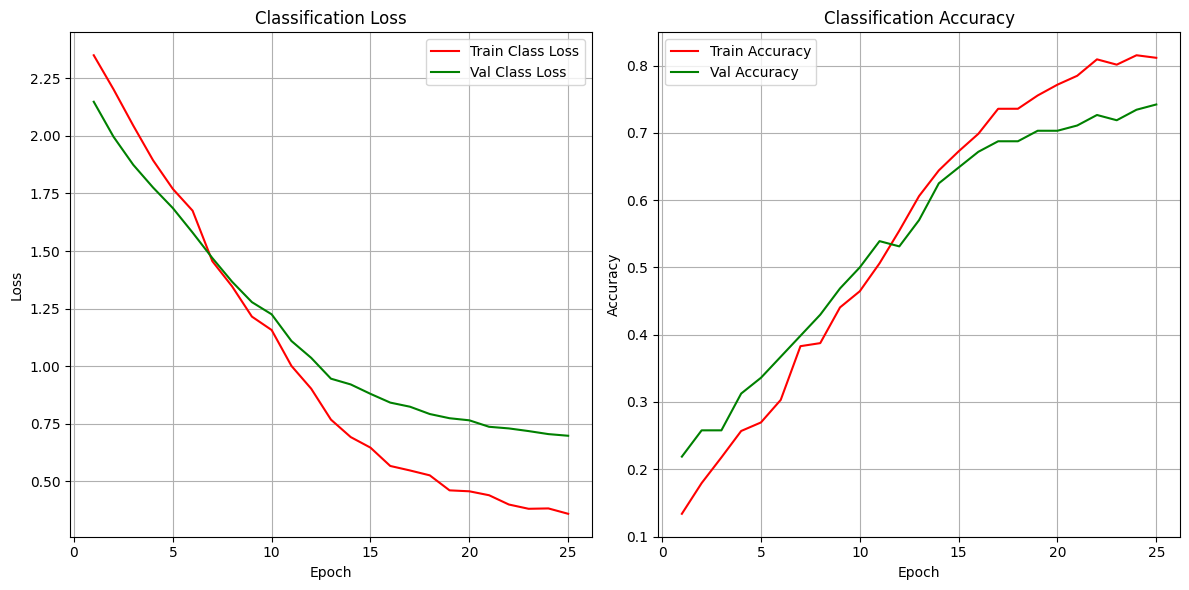

In [57]:
plot_multitask_training(history)
# history.keys()

Confusion Matrix: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


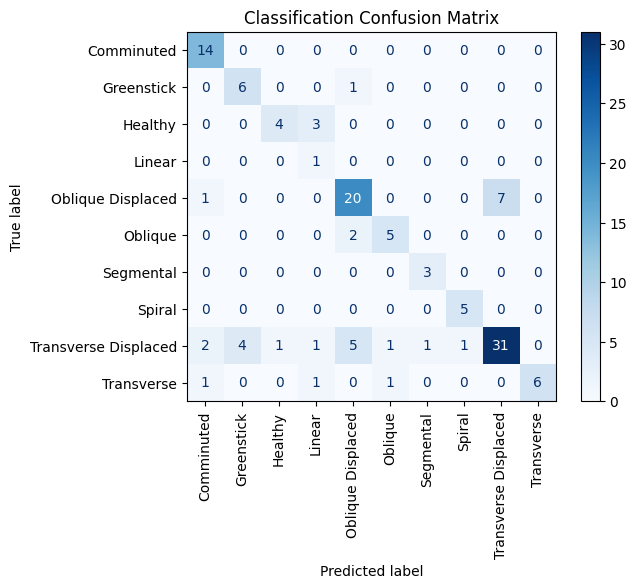

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def compute_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, class_ids_batch, _ in tqdm(dataloader, desc="Confusion Matrix"):
            y_true = to_label_tensor(class_ids_batch)
            valid_mask = (y_true != -1)
            if valid_mask.sum().item() == 0:
                continue
            x = images[valid_mask].to(device)
            y_true = y_true[valid_mask].to(device)
            logits, _ = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_true.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=90)
    plt.title("Classification Confusion Matrix")
    plt.show()

# ---- Example call ----
class_names = ['Comminuted', 'Greenstick', 'Healthy', 'Linear', 'Oblique Displaced', 'Oblique', 'Segmental', 'Spiral', 'Transverse Displaced', 'Transverse']
compute_confusion_matrix(model, val_loader, device, class_names)


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]



🧪 Test Results:  Class Loss=0.6188,  BBox Loss=0.9033,  Acc=0.7812


Confusion Matrix: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


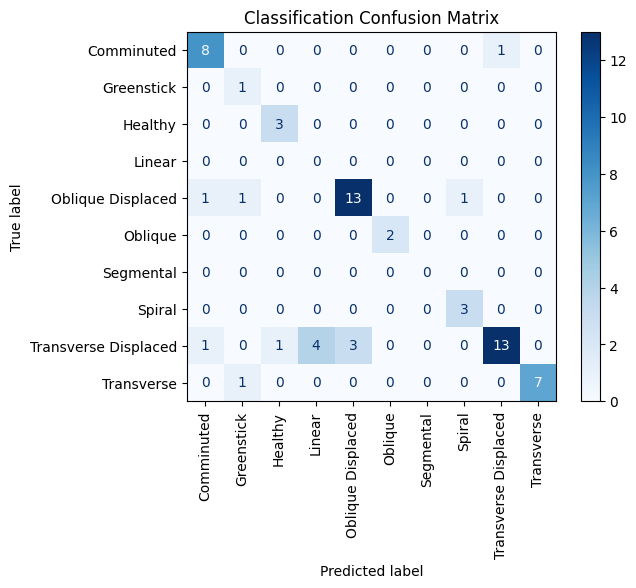

In [59]:
def test_model(model, dataloader, class_loss_fn, bbox_loss_fn, device, lambda_bbox=1.0):
    model.eval()
    total_class_loss = total_bbox_loss = total_acc = 0.0
    num_classes = get_num_classes_from_model(model)

    with torch.no_grad():
        for images, class_ids_batch, bboxes_batch in tqdm(dataloader, desc="Testing"):
            y = to_label_tensor(class_ids_batch)
            bbox_targets = to_bbox_tensor(bboxes_batch)
            valid_mask = (y != -1)
            if valid_mask.sum().item() == 0:
                continue

            x = images[valid_mask].to(device)
            y = y[valid_mask].to(device)
            bbox_targets = bbox_targets[valid_mask].to(device)

            if y.min().item() < 0 or y.max().item() >= num_classes:
                continue

            class_outputs, bbox_outputs = model(x)
            class_loss = class_loss_fn(class_outputs, y)
            bbox_loss = bbox_loss_fn(bbox_outputs, bbox_targets)

            preds = torch.argmax(class_outputs, dim=1)
            acc = (preds == y).float().mean().item()

            total_class_loss += class_loss.item()
            total_bbox_loss += bbox_loss.item()
            total_acc += acc

    n = max(len(dataloader), 1)
    print(f"\n🧪 Test Results:  "
          f"Class Loss={total_class_loss/n:.4f},  "
          f"BBox Loss={total_bbox_loss/n:.4f},  "
          f"Acc={total_acc/n:.4f}")
    return total_class_loss/n, total_bbox_loss/n, total_acc/n

# ---- Example call ----
test_class_loss, test_bbox_loss, test_acc = test_model(
    model, test_loader, class_loss_fn, bbox_loss_fn, device)


compute_confusion_matrix(model, test_loader, device, class_names)


In [60]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

def gradcam_pytorch(model, dataset, device, idx=0, class_names=None):
    """
    Minimal Grad-CAM for DeiT classification head — no external libs.
    """
    model.eval()
    image, class_ids, _ = dataset[idx]
    x = image.unsqueeze(0).to(device)

    # pick the last conv/embedding layer inside the backbone
    target_module = model.backbone.blocks[-1].mlp.fc2  # works well for DeiT

    # ---- register hooks ----
    activations = {}
    gradients = {}

    def fwd_hook(_, inp, out):
        activations['value'] = out.detach()

    def bwd_hook(_, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    h1 = target_module.register_forward_hook(fwd_hook)
    h2 = target_module.register_backward_hook(bwd_hook)

    # ---- forward pass ----
    class_logits, _ = model(x)
    pred_class = torch.argmax(class_logits, dim=1).item()

    # ---- backward pass ----
    model.zero_grad()
    class_logits[0, pred_class].backward()

    # ---- compute Grad-CAM ----
    grads = gradients['value']       # [B, C, ...]
    acts  = activations['value']     # [B, C, ...]
    weights = grads.mean(dim=(2, 3), keepdim=True) if grads.ndim == 4 else grads.mean(dim=1, keepdim=True)
    cam = (weights * acts).sum(dim=1).squeeze()
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()
    cam = cam.cpu().numpy()
    cam = cv2.GaussianBlur(cam, (7, 7), 0)

    # ---- resize to image size ----
    h, w = image.shape[1:]
    cam = cv2.resize(cam, (w, h))

    # ---- overlay ----
    img_np = image.permute(1,2,0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap[...,::-1]) / 255
    overlay = 0.5*heatmap + 0.5*img_np

    pred_name = class_names[pred_class] if class_names else f"class {pred_class}"
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.title(f"Grad-CAM Heatmap — Predicted: {pred_name}")
    plt.axis('off')
    plt.show()

    h1.remove(); h2.remove()


d:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\bfd\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


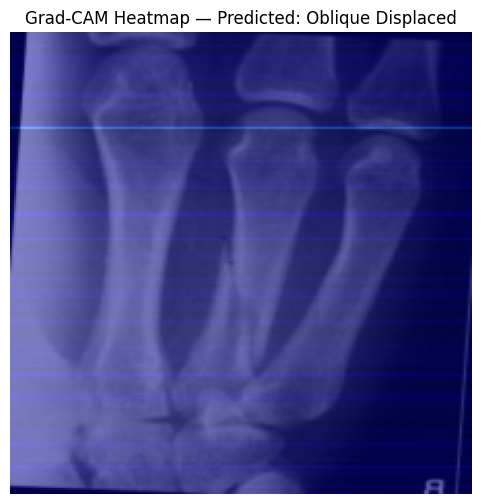

In [61]:
class_names = ['Comminuted', 'Greenstick', 'Healthy', 'Linear', 'Oblique Displaced', 'Oblique', 'Segmental', 'Spiral', 'Transverse Displaced', 'Transverse']

gradcam_pytorch(model, test_dataset, device, idx=10, class_names=class_names)

In [104]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_attention_deit(model, dataset, device, idx=0, class_names=None, layers="all", head_fusion="mean"):
    """
    Visualize DeiT/Vision Transformer attention maps using manual QK recomputation.
    Works with any timm DeiT model.
    - layers: "all" or list of layer indices to visualize
    - head_fusion: "mean" or "max"
    """
    model.eval()
    image, class_ids, _ = dataset[idx]
    img_tensor = image.unsqueeze(0).to(device)
    attention_maps = []

    # ---- Hook to extract Q, K, and compute attention ----
    def hook_fn(module, input, output):
        B, N, C = input[0].shape
        qkv = module.qkv(input[0])  # (B, N, 3*embed_dim)
        qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        attention_maps.append(attn.detach().cpu())

    # ---- Register hooks ----
    hooks = []
    for i, block in enumerate(model.backbone.blocks):
        if layers == "all" or (isinstance(layers, (list, tuple)) and i in layers):
            hooks.append(block.attn.register_forward_hook(hook_fn))

    # ---- Forward pass ----
    with torch.no_grad():
        logits, _ = model(img_tensor)
    for h in hooks:
        h.remove()

    if not attention_maps:
        print("⚠️ No attention maps captured. Check layer naming.")
        return

    # ---- Choose which attention layer(s) to visualize ----
    attn = attention_maps[11][0]  # [num_heads, N, N]
    if head_fusion == "mean":
        attn = attn.mean(0)
    elif head_fusion == "max":
        attn = attn.max(0)[0]

    # ---- CLS attention to patch tokens ----
    cls_attn = attn[0, 1:]
    num_patches = cls_attn.shape[0]
    grid_size = int(np.sqrt(num_patches))
    cls_attn = cls_attn.reshape(grid_size, grid_size)
    cls_attn = cls_attn / cls_attn.max()

    # ---- Upsample and overlay ----
    attn_map = cv2.resize(cls_attn.numpy(), (image.shape[2], image.shape[1]))
    img_np = image.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * attn_map), cv2.COLORMAP_JET)[..., ::-1] / 255
    overlay = 0.5 * img_np + 0.5 * heatmap

    pred_class = torch.argmax(logits, dim=1).item()
    pred_name = class_names[pred_class] if class_names else f"class {pred_class}"

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.title(f"DeiT Attention (Layer {len(attention_maps)-1}) — Pred: {pred_name}")
    plt.axis("off")
    plt.show()


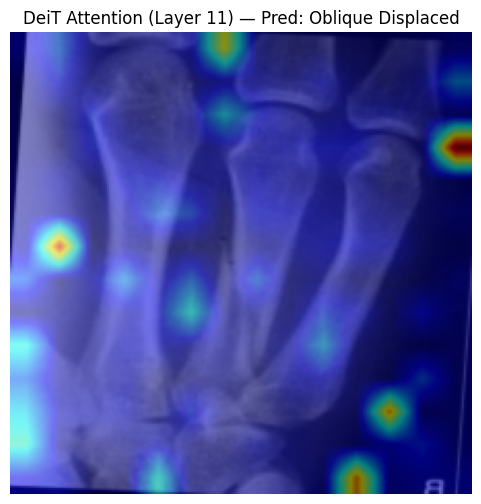

In [105]:
# class_names = [f"class_{i}" for i in range(num_classes)]
visualize_attention_deit(model, test_dataset, device, idx=10, class_names=class_names)


In [64]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def box_iou(box1, box2):
    """
    Compute IoU (Intersection over Union) between two boxes or batches of boxes.
    Format: [x_center, y_center, width, height] normalized in [0,1].
    Supports single boxes (shape [4]) or batched boxes ([N,4]).
    Returns a tensor of IoU values.
    """
    if isinstance(box1, (list, tuple)):
        box1 = torch.tensor(box1, dtype=torch.float32)
    if isinstance(box2, (list, tuple)):
        box2 = torch.tensor(box2, dtype=torch.float32)

    if box1.ndim == 1:
        box1 = box1.unsqueeze(0)
    if box2.ndim == 1:
        box2 = box2.unsqueeze(0)

    # Convert (cx, cy, w, h) → (x1, y1, x2, y2)
    b1_x1 = box1[:, 0] - box1[:, 2] / 2
    b1_y1 = box1[:, 1] - box1[:, 3] / 2
    b1_x2 = box1[:, 0] + box1[:, 2] / 2
    b1_y2 = box1[:, 1] + box1[:, 3] / 2

    b2_x1 = box2[:, 0] - box2[:, 2] / 2
    b2_y1 = box2[:, 1] - box2[:, 3] / 2
    b2_x2 = box2[:, 0] + box2[:, 2] / 2
    b2_y2 = box2[:, 1] + box2[:, 3] / 2

    # Intersection
    inter_x1 = torch.max(b1_x1, b2_x1)
    inter_y1 = torch.max(b1_y1, b2_y1)
    inter_x2 = torch.min(b1_x2, b2_x2)
    inter_y2 = torch.min(b1_y2, b2_y2)
    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)

    # Union
    area1 = (b1_x2 - b1_x1).clamp(0) * (b1_y2 - b1_y1).clamp(0)
    area2 = (b2_x2 - b2_x1).clamp(0) * (b2_y2 - b2_y1).clamp(0)
    union = area1 + area2 - inter_area + 1e-6  # small eps to avoid div by zero

    iou = inter_area / union
    return iou.squeeze()


def show_prediction(model, dataset, device, idx=0, class_names=None, show_iou=True):
    """
    Display predicted and ground-truth bounding boxes for a sample.
    - Predicted box: lime (green)
    - Ground-truth box: red
    Handles 0-dim or 1-dim tensors safely.
    """
    model.eval()
    image, class_ids, bbox_gt = dataset[idx]

    # ---- Handle class_ids safely ----
    if isinstance(class_ids, torch.Tensor):
        if class_ids.ndim == 0:
            true_label = int(class_ids.item())
        else:
            true_label = int(class_ids.view(-1)[0].item())
    elif isinstance(class_ids, (list, tuple)):
        val = class_ids[0]
        true_label = int(val.item() if isinstance(val, torch.Tensor) else val)
    else:
        true_label = int(class_ids)

    # ---- Handle bbox_gt safely ----
    if isinstance(bbox_gt, torch.Tensor):
        bbox_gt = bbox_gt.view(-1)  # flatten to shape [4]
    elif isinstance(bbox_gt, (list, tuple)):
        bbox_gt = torch.tensor(bbox_gt[:4], dtype=torch.float32)
    else:
        raise TypeError(f"Unsupported bbox type: {type(bbox_gt)}")

    with torch.no_grad():
        x = image.unsqueeze(0).to(device)
        class_logits, bbox_preds = model(x)
        pred_label = torch.argmax(class_logits, dim=1).item()
        pred_bbox = bbox_preds[0].cpu().view(-1)

    # ---- Compute IoU (optional) ----
    iou_val = box_iou(pred_bbox, bbox_gt).item() if show_iou else None

    # ---- Convert normalized boxes to pixel coordinates ----
    img_np = image.permute(1, 2, 0).cpu().numpy()
    h, w = img_np.shape[:2]

    def to_xywh(box):
        cx, cy, bw, bh = box
        return (cx - bw / 2) * w, (cy - bh / 2) * h, bw * w, bh * h

    x1_p, y1_p, bw_p, bh_p = to_xywh(pred_bbox)
    x1_g, y1_g, bw_g, bh_g = to_xywh(bbox_gt)

    # ---- Plot ----
    fig, ax = plt.subplots(1, figsize=(7,7))
    ax.imshow(img_np)

    # Predicted box
    rect_pred = patches.Rectangle((x1_p, y1_p), bw_p, bh_p, linewidth=2,
                                  edgecolor='lime', facecolor='none', label='Predicted')
    ax.add_patch(rect_pred)

    # Ground-truth box
    rect_gt = patches.Rectangle((x1_g, y1_g), bw_g, bh_g, linewidth=2,
                                edgecolor='red', facecolor='none', label='Ground Truth')
    ax.add_patch(rect_gt)

    # Labels
    pred_name = class_names[pred_label] if class_names else f"Pred {pred_label}"
    true_name = class_names[true_label] if class_names else f"GT {true_label}"
    ax.text(x1_p, y1_p - 5, f"Pred: {pred_name}", color='lime', fontsize=11, weight='bold')
    ax.text(x1_g, y1_g - 20, f"GT: {true_name}", color='red', fontsize=11, weight='bold')

    if iou_val is not None:
        ax.text(10, 20, f"IoU = {iou_val:.2f}", color='yellow', fontsize=13, weight='bold',
                bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'))

    plt.axis('off')
    plt.title("Prediction vs Ground Truth")
    plt.legend(loc='upper right')
    plt.show()




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].


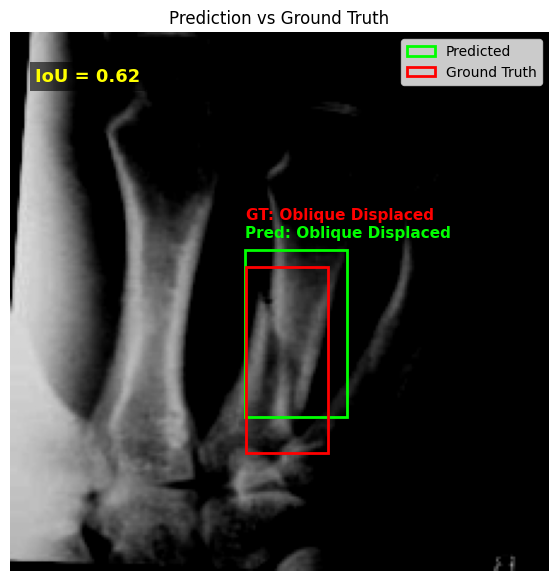

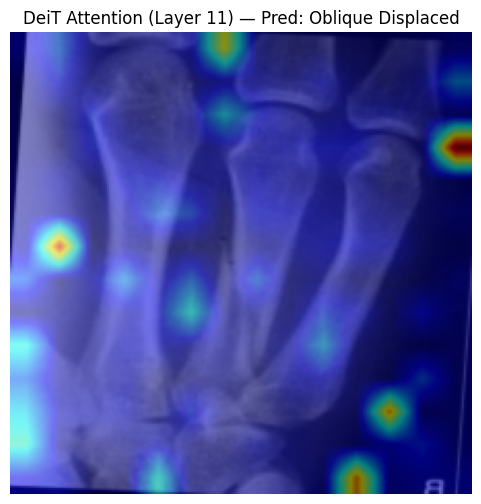

In [97]:
class_names = ['Comminuted', 'Greenstick', 'Healthy', 'Linear', 'Oblique Displaced', 'Oblique', 'Segmental', 'Spiral', 'Transverse Displaced', 'Transverse']

# Show a sample prediction vs ground truth
show_prediction(model, test_dataset, device, idx=10, class_names=class_names)
visualize_attention_deit(model, test_dataset, device, idx=10, class_names=class_names)
# gradcam_pytorch(model, test_dataset, device, idx=10, class_names=class_names)

In [91]:
def describe_prediction(class_logits, bbox, class_names, image_size=(640, 640)):
    """
    Generate a diagnostic-style sentence for the model's prediction.

    Args:
        class_logits: torch.Tensor [num_classes] – raw model output for classes
        bbox: torch.Tensor [4] – predicted bounding box (x_center, y_center, w, h) normalized
        class_names: list[str] – list of fracture types or labels
        image_size: (width, height) – original image size for reference

    Returns:
        sentence: str
    """
    # --- classification prediction ---
    probs = torch.softmax(class_logits, dim=0)
    conf, class_id = torch.max(probs, dim=0)
    class_label = class_names[class_id.item()]

    # --- bounding box location ---
    x_center, y_center, w, h = bbox.tolist()
    W, H = image_size

    # region interpretation
    vertical = "upper" if y_center < 0.33 else "middle" if y_center < 0.66 else "lower"
    horizontal = "left" if x_center < 0.33 else "center" if x_center < 0.66 else "right"

    # --- convert to pixels for readability ---
    x_px, y_px = int(x_center * W), int(y_center * H)

    # --- formatted sentence ---
    sentence = (f"{class_label.capitalize()} fracture found in the "
                f"{vertical}-{horizontal} region of the image "
                f"(center: {x_px}px, {y_px}px) with confidence {conf.item() * 100:.1f}%.")
    return sentence


In [96]:
# Example prediction
image, class_ids, bboxes = test_dataset[10]
x = image.unsqueeze(0).to(device)

class_logits, bbox_preds = model(x)
class_logits = class_logits[0].detach().cpu()
bbox_pred = bbox_preds[0].detach().cpu()

class_names = ['Comminuted', 'Greenstick', 'Healthy', 'Linear', 'Oblique Displaced', 'Oblique', 'Segmental', 'Spiral', 'Transverse Displaced', 'Transverse']

caption = describe_prediction(class_logits, bbox_pred, class_names, image_size=(640, 640))
print(caption)


Oblique displaced fracture found in the middle-center region of the image (center: 338px, 356px) with confidence 78.4%.


In [126]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def generate_prediction_report(model, dataset, device, idx=0, class_names=None, show_gt=False, save_path=None):
    """
    Generate visual + textual prediction report for one sample.
    Shows predicted bounding box, confidence, and a descriptive sentence.
    """
    model.eval()
    image, true_label, true_bbox = dataset[idx]
    img_tensor = image.unsqueeze(0).to(device)
    _, h, w = image.shape

    # ---- Forward pass ----
    with torch.no_grad():
        class_logits, bbox_preds = model(img_tensor)
        probs = torch.softmax(class_logits, dim=1)[0]
        pred_class = torch.argmax(probs).item()
        confidence = probs[pred_class].item() * 100
        bbox_pred = bbox_preds[0].cpu().numpy()

    # ---- Decode bbox (normalized cx, cy, w, h → xyxy) ----
    x_c, y_c, bw, bh = bbox_pred
    x1 = (x_c - bw / 2) * w
    y1 = (y_c - bh / 2) * h
    x2 = (x_c + bw / 2) * w
    y2 = (y_c + bh / 2) * h

    # ---- Determine approximate region ----
    x_regions = ["left", "center", "right"]
    y_regions = ["upper", "middle", "lower"]
    x_region = x_regions[int(np.clip((x_c * 3), 0, 2))]
    y_region = y_regions[int(np.clip((y_c * 3), 0, 2))]
    region_desc = f"{y_region}-{x_region}"

    # ---- Sentence generation ----
    class_name = class_names[pred_class] if class_names else f"class {pred_class}"
    sentence = f"{class_name.capitalize()} fracture found in the {region_desc} region of the scan with confidence {confidence:.1f}%."

    # ---- Convert image tensor for visualization ----
    img_np = image.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    img_vis = (img_np * 255).astype(np.uint8)
    img_vis = cv2.cvtColor(img_vis, cv2.COLOR_RGB2BGR)

    # ---- Draw predicted bbox ----
    cv2.rectangle(img_vis, (int(x1), int(y1)), (int(x2), int(y2)), (200, 0, 0), 1)
    # cv2.putText(img_vis, f"{class_name} ({confidence:.1f}%)", (int(x1), int(y1) - 10),
    #             cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # ---- Optional: draw GT bbox ----
    if show_gt and isinstance(true_bbox, torch.Tensor):
        tb = true_bbox.detach().cpu().numpy()
        # Ensure shape [4]
        if tb.ndim == 2 and tb.shape[0] == 1:
            tb = tb[0]
        elif tb.ndim == 0 or tb.size == 4:
            tb = np.array(tb).reshape(4)
        elif tb.ndim > 2:
            tb = tb.reshape(-1, 4)[0]

        tx1 = (tb[0] - tb[2] / 2) * w
        ty1 = (tb[1] - tb[3] / 2) * h
        tx2 = (tb[0] + tb[2] / 2) * w
        ty2 = (tb[1] + tb[3] / 2) * h

        cv2.rectangle(img_vis, (int(tx1), int(ty1)), (int(tx2), int(ty2)), (0, 255, 0), 2)


    # ---- Plot ----
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(sentence, fontsize=11, wrap=True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    # print("🩻", sentence)



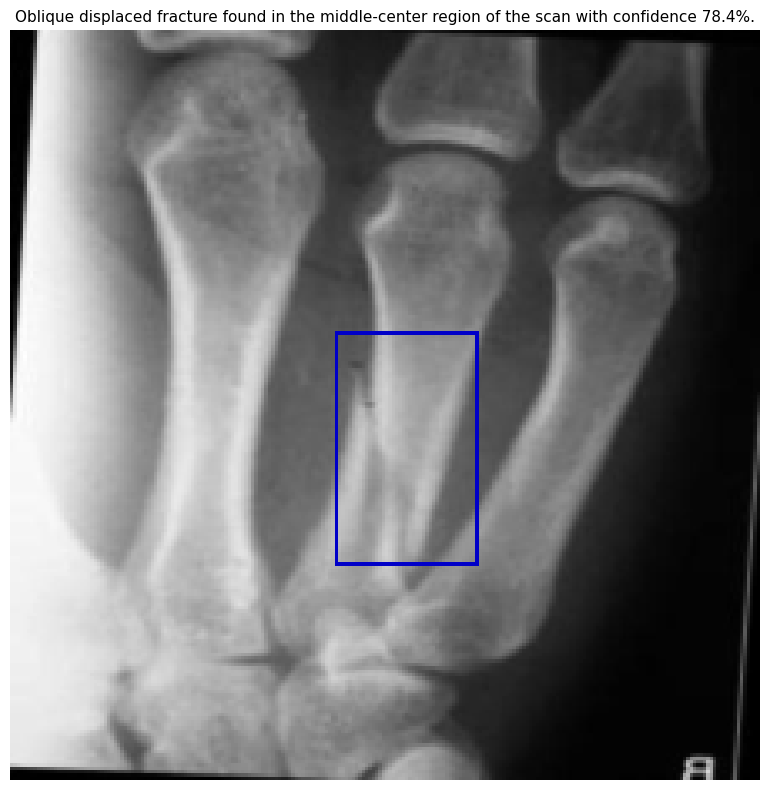

In [127]:
generate_prediction_report(model, test_dataset, device, idx=10, class_names=class_names)